In [1]:
import cmocean 
import cosima_cookbook as cc
import dask.distributed as dsk
import gsw
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import xesmf as xe
import xgcm
from joblib import Parallel, delayed

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:40147 Dashboard: /proxy/8787/status,Cluster Workers: 7 Cores: 28 Memory: 250.00 GiB


In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'
session_eas = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
experiment_eup = '01deg_jra55v13_ryf9091_easterlies_up10'
experiment_edo = '01deg_jra55v13_ryf9091_easterlies_down10'

ti = '2150-01-01'
tf = '2150-12-31'

### Load mass transport (kg/s)

In [82]:
tx = cc.querying.getvar(experiment_ryf, 'tx_trans', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, tf), yt_ocean = slice(-80, -58))
ty = cc.querying.getvar(experiment_ryf, 'ty_trans', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, tf), yu_ocean = slice(-80, -58))

### Old slow regridding

In [6]:
# Regrid
ds_in = tx.rename({'yt_ocean':'yu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
regrid = xe.Regridder(ds_in, ds_out, 'conservative')
dr_out = regrid(ds_in)
tx = dr_out['tx_trans']
ds_in = ty.rename({'xt_ocean':'xu_ocean'}).chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()
regrid = xe.Regridder(ds_in, ds_out, 'conservative')
dr_out = regrid(ds_in)
ty = dr_out['ty_trans']

In [32]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')
ds_out = grid['hu'].sel(yu_ocean = slice(-80,-58)).drop('geolon_c').drop('geolat_c').chunk({'xu_ocean':-1, 'yu_ocean':-1}).to_dataset()

### Move it fast to u grid and divide

In [83]:
tx = tx.rename({'yt_ocean':'yu_ocean'}).interp(yu_ocean = ty['yu_ocean'])
ty = ty.rename({'xt_ocean':'xu_ocean'}).interp(xu_ocean = tx['xu_ocean'])

### Calculate cross slope transport

In [33]:
# Give information on the grid: location of u (momentum) and t (tracer) points on B-grid 
ds = grid.copy()
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid_x = xgcm.Grid(ds, periodic=['X'])

# Take topographic gradient (simple gradient over one grid cell) and move back to u-grid
dhu_dx = grid_x.interp( grid_x.diff(ds.hu, 'X') / grid_x.interp(ds.dxu, 'X'), 'X')
# In meridional direction, we need to specify what happens at the boundary
dhu_dy = grid_x.interp( grid_x.diff(ds.hu, 'Y', boundary='extend') / grid_x.interp(ds.dyt, 'X'), 'Y', boundary='extend')
# Magnitude of the topographic slope (to normalise the topographic gradient)
topographic_slope_magnitude = np.sqrt(dhu_dx**2 + dhu_dy**2)

dhu_dx = dhu_dx.sel(yu_ocean = slice(-80, -58))
dhu_dy = dhu_dy.sel(yu_ocean = slice(-80, -58))
topographic_slope_magnitude = topographic_slope_magnitude.sel(yu_ocean = slice(-80, -58))

In [84]:
t_proj = (tx*dhu_dx/topographic_slope_magnitude + ty*dhu_dy/topographic_slope_magnitude)

In [85]:
t_proj = t_proj.load()

### Extract along the isobath

In [44]:
isobath_depth = 1500
file_path = '/g/data/x77/wgh581/Post_Process/Antarctic_slope_contour_u_t_' + str(isobath_depth) + 'm_plt_approach.npz'
data = np.load(file_path)
# We are interested in the u-grid:
num_points = data['num_points_u']
distance_along_contour = data['distance_along_contour_u']
lon_along_contour = data['lon_along_contour_u']
lat_along_contour = data['lat_along_contour_u']

In [86]:
t_across_contour = np.zeros((len(t_proj['time']), len(t_proj['st_ocean']), len(lon_along_contour)))
def extract_isobath(i):
    t_across_contour[:, :, i] = t_proj.sel(xu_ocean = lon_along_contour[i], method = 'nearest').sel(yu_ocean = lat_along_contour[i], method = 'nearest').values            

In [88]:
Parallel(n_jobs = 1)(delayed(extract_isobath)(n) for n in range(num_points)); 

In [89]:
t_across_contour = xr.DataArray(t_across_contour)

In [90]:
t_across_contour = t_across_contour.rename({'dim_0':'time', 'dim_1':'st_ocean', 'dim_2':'lon_along_contour'})

In [91]:
t_across_contour['time'] = t_proj['time'].values
t_across_contour['st_ocean'] = t_proj['st_ocean'].values
t_across_contour['lon_along_contour'] = lon_along_contour

### Get sigma1

In [97]:
temp = cc.querying.getvar(experiment_ryf, 'temp', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, tf), yt_ocean = slice(-80, -58))-273.15
salt = cc.querying.getvar(experiment_ryf, 'salt', session_ryf, start_time = ti, end_time = tf).sel(time = slice(ti, tf), yt_ocean = slice(-80, -58))

p = gsw.p_from_z(-temp['st_ocean'], temp['yt_ocean'])
salt_abs = gsw.SA_from_SP(salt, p, salt['xt_ocean'], salt['yt_ocean'])

sigma1 = gsw.sigma1(salt_abs, temp)
sigma1 = sigma1.rename({'yt_ocean':'yu_ocean', 'xt_ocean':'xu_ocean'})
sigma1 = sigma1.interp(xu_ocean = dhu_dx['xu_ocean'], yu_ocean = dhu_dx['yu_ocean'])

In [98]:
sigma1 = sigma1.load()

In [99]:
def extract_isobath(i):
    sigma1_isobath[:, :, i] = sigma1.sel(xu_ocean = lon_along_contour[i], method = 'nearest').sel(yu_ocean = lat_along_contour[i], method = 'nearest')            

In [101]:
sigma1_isobath = np.zeros((len(sigma1['time']), len(sigma1['st_ocean']), len(lon_along_contour)))
Parallel(n_jobs = 1)(delayed(extract_isobath)(n) for n in range(num_points)); 

In [110]:
sigma1_isobath = xr.DataArray(sigma1_isobath, dims = t_across_contour.dims, coords = t_across_contour.coords)

Check it out

In [ ]:
plt.figure(figsize = (20,5))
plt.pcolormesh(t_across_contour['lon_along_contour'], -t_across_contour['st_ocean'], t_across_contour.mean('time')/(1e6*1035), vmin = -.03, vmax = .03, cmap = cmocean.cm.curl)
plt.colorbar().set_label('Transport [SV]')
plt.contour(sigma1_isobath['lon_along_contour'], -sigma1_isobath['st_ocean'], sigma1_isobath.mean('time'), levels = [32.5], colors = ['k'])
plt.ylim(-2000, None)
plt.xlabel('Longitude')
plt.ylabel('Depth')
plt.savefig('test.jpg', bbox_inches = 'tight')

(-2000.0, -0.5412807653916101)

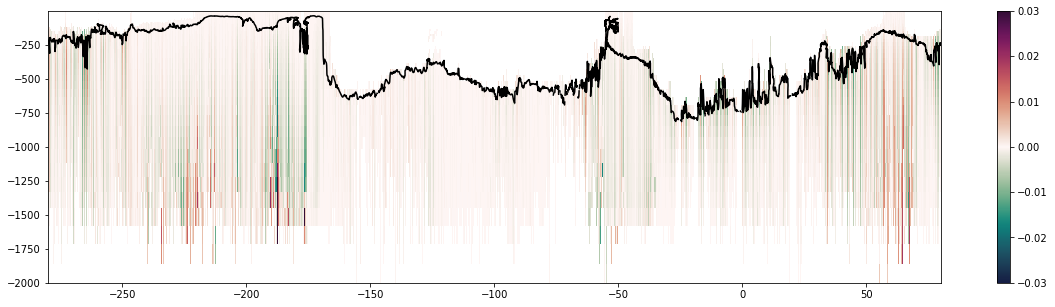

In [127]:
plt.figure(figsize = (20,5))
plt.pcolormesh(t_across_contour['lon_along_contour'], -t_across_contour['st_ocean'], 
               t_across_contour.where(sigma1_isobath<32.8).where(sigma1_isobath>32.5).mean('time')/(1e6*1035), 
               vmin = -.03, vmax = .03, cmap = cmocean.cm.curl)
plt.colorbar()
plt.contour(sigma1_isobath['lon_along_contour'], -sigma1_isobath['st_ocean'], sigma1_isobath.mean('time'), levels = [32.5], colors = ['k'])
plt.ylim(-2000, None)

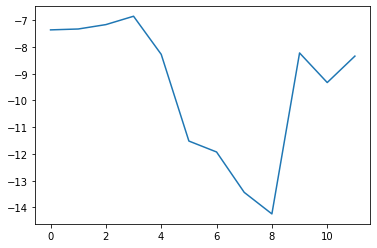

In [164]:
plt.plot(t_across_contour.where(sigma1_isobath<32.8).where(sigma1_isobath>32.5).sum(['st_ocean', 'lon_along_contour'])/(1e6*1035))